In [7]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from torch import nn
from sklearn import metrics
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import warnings
warnings.filterwarnings('ignore')

In [24]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/train_data(1%)_down.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/test_data(1%)_down.csv")

####################################################################

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# # Down Sampling
# # train 데이터의 레이블 비율 확인
# train_labels = train_data['y']
# label_counts = train_labels.value_counts()

# # train 데이터의 레이블 비율이 1:1이 되도록 분할
# class_0_data = train_data[train_data['y'] == 0]
# class_1_data = train_data[train_data['y'] == 1]

# # 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# num_samples = min(label_counts[0], label_counts[1])
# class_0_data = class_0_data.sample(num_samples, random_state=42)

# # 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# class_1_data = class_1_data.sample(num_samples, random_state=42)

# # 선택한 데이터를 결합하여 최종 train 데이터 생성
# train_data = pd.concat([class_0_data, class_1_data])
####################################################################


# train_data split
train_data, valid_data, _, _ = train_test_split(train_data, train_data['y'], test_size=0.2, random_state=42)


# 데이터 분할 결과 확인
print("Train Data:")
print(train_data['y'].value_counts())
print("Validation Data:")
print(valid_data['y'].value_counts())
print("Test Data:")
print(test_data['y'].value_counts())

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']

X_valid = valid_data.drop('y', axis=1)
y_valid = valid_data['y']

X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

clf = TabNetClassifier(cat_emb_dim=3,
                       optimizer_fn=torch.optim.AdamW, # Any optimizer works here
                       mask_type='entmax', # "sparsemax",
                      )

# NaN 값 대체
imputer = SimpleImputer(strategy='mean')
X_train_array = imputer.fit_transform(X_train)
X_valid_array = imputer.transform(X_valid)
X_test_array = imputer.transform(X_test)

# 데이터 스케일링
scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train_array)
X_valid_array = scaler.transform(X_valid_array)
X_test_array = scaler.transform(X_test_array)

# NaN 값 대체
y_imputer = SimpleImputer(strategy='mean')
y_train_array = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_array = y_imputer.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_array = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()

Train Data:
0    394
1    388
Name: y, dtype: int64
Validation Data:
1    101
0     95
Name: y, dtype: int64
Test Data:
0    341
1    116
Name: y, dtype: int64


In [25]:
# 초기화
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
auroc_list = []

# 10번 반복
for i in range(10):
    # 랜덤한 파라미터 생성
    n_d = random.randint(16, 64)  # n_d 파라미터 설정 (예: 16에서 64 사이의 랜덤한 값)
    n_a = random.randint(8, 32)   # n_a 파라미터 설정 (예: 8에서 32 사이의 랜덤한 값)
    max_epochs = 300 + i * 10     # max_epochs 설정 (예: 10부터 100까지 10 단위로 증가)

    # 모델 생성
    clf = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size": 50, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type="entmax",  # "sparsemax" 또는 "gumbel"로 변경 가능
    )

    # 모델 훈련
    clf.fit(
        X_train=X_train_array, y_train=y_train_array,
        eval_set=[(X_train_array, y_train_array), (X_valid_array, y_valid_array)],
        eval_metric=["accuracy"],
        max_epochs=max_epochs,
        patience=50,
        batch_size=1024,  # 원하는 배치 크기로 변경 가능
    )

    # 모델 예측
    y_pred_test = clf.predict(X_test_array)
    y_pred_score = clf.predict_proba(X_test_array)

    # 평가 메트릭 계산
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auroc = roc_auc_score(y_test, y_pred_test)
    auroc1 = roc_auc_score(y_test, y_pred_score[:,1])

    # 결과를 리스트에 추가
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    y_pred_list.append(y_pred_test)
    auroc_list.append(auroc)

    # 매 반복마다 결과 출력
    print(f"Iteration {i + 1}:")
    print("Test Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUROC:", auroc)
    print("")

# 평균 및 표준편차 계산 (예를 들어, accuracy의 평균과 표준편차)
mean_accuracy = pd.Series(accuracy_list).mean()
std_accuracy = pd.Series(accuracy_list).std()

# 다른 메트릭에 대해서도 평균과 표준편차를 계산할 수 있습니다.

# 결과 출력
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)


epoch 0  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_accuracy: 0.46931 | val_1_accuracy: 0.55612 |  0:00:00s
epoch 11 | loss: 0.0 

In [26]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC' : auroc_list,
    'Predictions': y_pred_list
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,0.634573,0.213483,0.163793,0.185366,0.479257,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.420131,0.229091,0.543103,0.322251,0.460701,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
2,0.293217,0.258741,0.956897,0.407339,0.512173,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0.630197,0.280992,0.293103,0.286920,0.518986,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,0.295405,0.253589,0.913793,0.397004,0.499419,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,0.273523,0.255656,0.974138,0.405018,0.504664,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,0.660832,0.169492,0.086207,0.114286,0.471256,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,0.693654,0.337838,0.215517,0.263158,0.535911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
8,0.663020,0.228571,0.137931,0.172043,0.489787,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
9,0.448578,0.209402,0.422414,0.280000,0.439946,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."


In [27]:
# 적용할 열(칼럼) 목록 지정
columns_to_process = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC']

# 지정한 열(칼럼)에 대해 100을 곱하고 소수점 둘째 자리까지만 남기기
df[columns_to_process] = df[columns_to_process].apply(lambda x: (x * 100).round(2))
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,63.46,21.35,16.38,18.54,47.93,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,42.01,22.91,54.31,32.23,46.07,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
2,29.32,25.87,95.69,40.73,51.22,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,63.02,28.10,29.31,28.69,51.90,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,29.54,25.36,91.38,39.70,49.94,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,27.35,25.57,97.41,40.50,50.47,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,66.08,16.95,8.62,11.43,47.13,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,69.37,33.78,21.55,26.32,53.59,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
8,66.30,22.86,13.79,17.20,48.98,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
9,44.86,20.94,42.24,28.00,43.99,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."


In [29]:
# DataFrame을 CSV 파일로 저장
df.to_csv('~/project/MIMIC-III/Model/Output/TabNet/TN(1%).csv', index=False)  # index를 저장하지 않으려면 index=False로 설정


accuracy: 0.4223194748358862
precision: 0.2643312101910828
recall: 0.7155172413793104
f1 score: 0.386046511627907

Confusion Matrix (Test Data):
[[110 231]
 [ 33  83]]


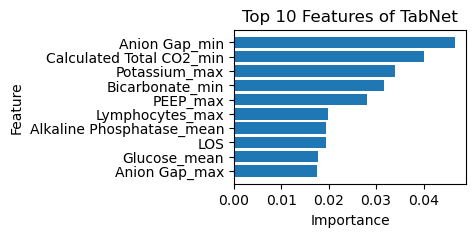

In [25]:
# 모델 예측
y_pred_test = clf.predict(X_test_array)

# 평가 메트릭 계산
accuracy = metrics.accuracy_score(y_test, y_pred_test)
print("accuracy:", accuracy)

precision = metrics.precision_score(y_test, y_pred_test)
print("precision:", precision)

recall = metrics.recall_score(y_test, y_pred_test)
print("recall:", recall)

f1 = metrics.f1_score(y_test, y_pred_test)
print("f1 score:", f1)

print("")

# 혼동 행렬 출력
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Data):")
print(conf_matrix_test)

# Feature selection
importance_scores = clf.feature_importances_
feature_names = X_train.columns

# X_train 데이터프레임의 열 수와 일치하지 않을 경우, 필요한 처리를 수행하여 일치시킴
if len(feature_names) > len(importance_scores):
    # X_train 데이터프레임의 열을 제거하거나 importance_scores에 0을 추가하여 길이를 맞춤
    importance_scores = np.concatenate([importance_scores, np.zeros(len(feature_names) - len(importance_scores))])
elif len(feature_names) < len(importance_scores):
    # importance_scores의 길이를 X_train 데이터프레임의 열 수에 맞게 잘라냄
    importance_scores = importance_scores[:len(feature_names)]

# 업데이트된 importance_scores로 데이터프레임 생성
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

# 나머지 코드는 이전과 동일
sorted_feature_importance = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = sorted_feature_importance.head(10)

plt.figure(figsize=(3, 2))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features of TabNet')
plt.gca().invert_yaxis()
plt.show()

Test Accuracy: 42.23
Precision: 26.43
Recall: 71.55
F1-score: 38.6
AUROC: 51.9

Confusion Matrix (Test Data):
[[110 231]
 [ 33  83]]


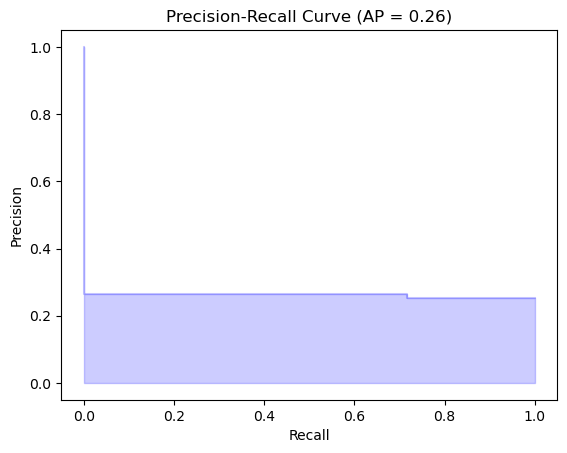

In [27]:
# 모델 예측
y_pred_test = clf.predict(X_test_array)

# 평가 메트릭 계산
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
auroc = roc_auc_score(y_test, y_pred_test)

rounded_accuracy = round(accuracy * 100, 2)
rounded_precision = round(precision * 100, 2)
rounded_recall = round(recall * 100, 2)
rounded_f1 = round(f1 * 100, 2)
rounded_auroc = round(auroc * 100, 2)


print("Test Accuracy:", rounded_accuracy)
print("Precision:", rounded_precision)
print("Recall:", rounded_recall)
print("F1-score:", rounded_f1)
print("AUROC:", rounded_auroc)

print("")

# 혼동 행렬 출력
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Data):")
print(conf_matrix_test)

# Precision-Recall Curve 계산
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
average_precision = average_precision_score(y_test, y_pred_test)

# # Precision-Recall Curve 시각화
# plt.figure()
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
# plt.show()



In [31]:
83/(33+83)

0.7155172413793104

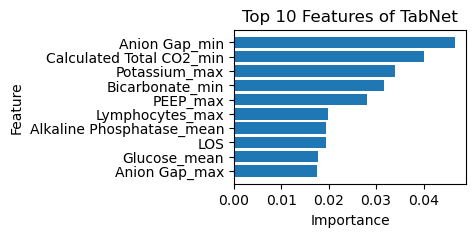

In [29]:
# Feature selection
importance_scores = clf.feature_importances_
feature_names = X_train.columns

# X_train 데이터프레임의 열 수와 일치하지 않을 경우, 필요한 처리를 수행하여 일치시킴
if len(feature_names) > len(importance_scores):
    # X_train 데이터프레임의 열을 제거하거나 importance_scores에 0을 추가하여 길이를 맞춤
    importance_scores = np.concatenate([importance_scores, np.zeros(len(feature_names) - len(importance_scores))])
elif len(feature_names) < len(importance_scores):
    # importance_scores의 길이를 X_train 데이터프레임의 열 수에 맞게 잘라냄
    importance_scores = importance_scores[:len(feature_names)]

# 업데이트된 importance_scores로 데이터프레임 생성
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

# 나머지 코드는 이전과 동일
sorted_feature_importance = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = sorted_feature_importance.head(10)

plt.figure(figsize=(3, 2))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features of TabNet')
plt.gca().invert_yaxis()
plt.show()